In [18]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [19]:
data_root = "/kaggle/input/wound-classification-using-images/wound-classification-using-images-and-locations-main/dataset/Train/Train"
csv_path = os.path.join(data_root, "wound_locations_Labels_AZH_Train.csv")

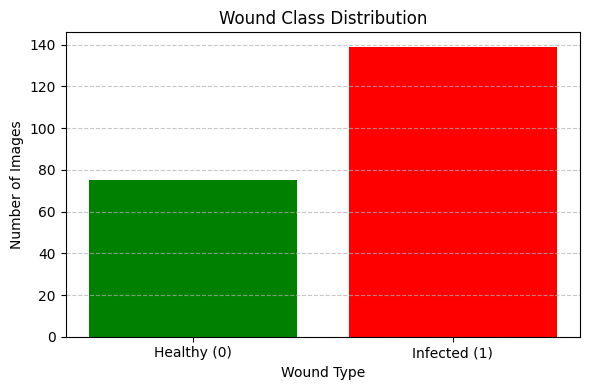

In [20]:
label_data = pd.read_csv(csv_path)
filtered_labels = label_data[label_data['Labels'].isin([0, 1])]
label_counts = filtered_labels['Labels'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.bar(['Healthy (0)', 'Infected (1)'], label_counts, color=['green', 'red'])
plt.title("Wound Class Distribution")
plt.xlabel("Wound Type")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
class WoundDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        rel_path = self.annotations.iloc[idx, 0].replace("\\", "/") + ".jpg"
        img_path = os.path.join(self.root_dir, rel_path)
        image = Image.open(img_path).convert("RGB")
        label = int(self.annotations.iloc[idx, 2])
        if self.transform:
            image = self.transform(image)
        return image, label

In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_df, val_df = train_test_split(filtered_labels, test_size=0.2, random_state=42)
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

train_dataset = WoundDataset("train.csv", data_root, transform=transform)
val_dataset = WoundDataset("val.csv", data_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [25]:
class SimpleWoundCNN(nn.Module):
    def __init__(self):
        super(SimpleWoundCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleWoundCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [27]:
model.train()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    break  # Just one batch for demo

In [28]:
model.eval()
val_correct, val_total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()
print(f"Validation Accuracy: {100 * val_correct / val_total:.2f}%")

Validation Accuracy: 72.09%


In [30]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        12
    Infected       0.72      1.00      0.84        31

    accuracy                           0.72        43
   macro avg       0.36      0.50      0.42        43
weighted avg       0.52      0.72      0.60        43



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


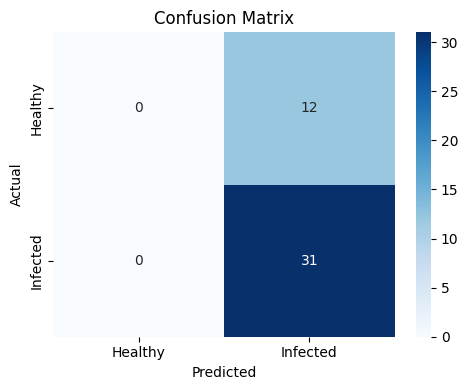

In [31]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Healthy', 'Infected']))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Infected'], yticklabels=['Healthy', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

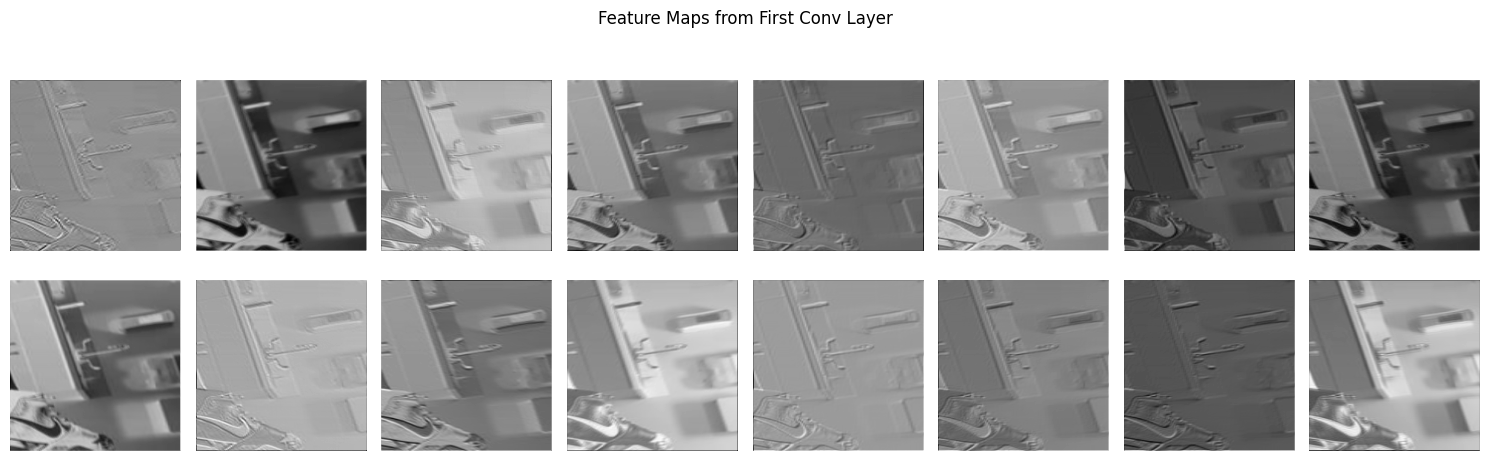

In [32]:
def visualize_feature_maps(model, image_tensor):
    model.eval()
    with torch.no_grad():
        x = image_tensor.unsqueeze(0).to(device)
        first_conv = model.conv_layer[0](x)  # Get output of first Conv2d
        fig, axes = plt.subplots(2, 8, figsize=(15, 5))
        for i, ax in enumerate(axes.flat):
            if i < 16:
                ax.imshow(first_conv[0, i].cpu().numpy(), cmap='gray')
                ax.axis('off')
        plt.suptitle("Feature Maps from First Conv Layer")
        plt.tight_layout()
        plt.show()

# Show feature maps from a single image in the validation set
sample_image, _ = val_dataset[0]
visualize_feature_maps(model, sample_image)

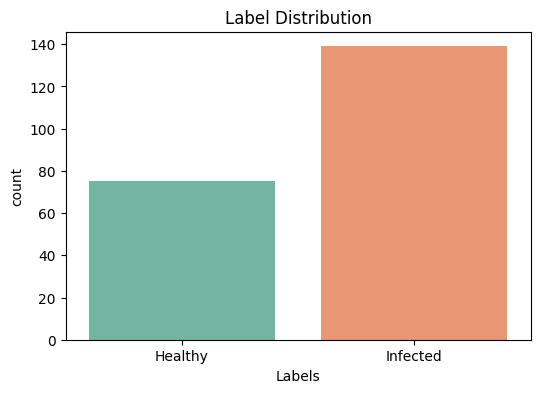

In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_root = "/kaggle/input/wound-classification-using-images/wound-classification-using-images-and-locations-main/dataset/Train/Train"
csv_path = os.path.join(data_root, "wound_locations_Labels_AZH_Train.csv")

df = pd.read_csv(csv_path)
df = df[df['Labels'].isin([0, 1])]

plt.figure(figsize=(6,4))
sns.countplot(x='Labels', data=df, palette='Set2')
plt.xticks([0,1], ['Healthy', 'Infected'])
plt.title('Label Distribution')
plt.show()

In [34]:
import torch
import torch.nn as nn

class SimpleWoundCNN(nn.Module):
    def __init__(self):
        super(SimpleWoundCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

print(SimpleWoundCNN())

SimpleWoundCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)



```dart
// Flutter MVP App for Wound Classification
import 'package:flutter/material.dart';
import 'package:image_picker/image_picker.dart';
import 'dart:io';

void main() => runApp(WoundApp());

class WoundApp extends StatelessWidget {
  @override
  Widget build(BuildContext context) {
    return MaterialApp(
      title: 'Wound Classifier',
      debugShowCheckedModeBanner: false,
      theme: ThemeData(primarySwatch: Colors.orange),
      home: HomePage(),
    );
  }
}

class HomePage extends StatefulWidget {
  @override
  _HomePageState createState() => _HomePageState();
}

class _HomePageState extends State<HomePage> {
  File? _image;
  String? _prediction;

  Future<void> _pickImage() async {
    final pickedFile = await ImagePicker().pickImage(source: ImageSource.gallery);
    if (pickedFile != null) {
      setState(() {
        _image = File(pickedFile.path);
        _prediction = null;
      });
      // TODO: Upload image to backend and get prediction
    }
  }

  Widget _buildPredictionResult() {
    if (_prediction != null) {
      return Column(
        children: [
          Text('Prediction:', style: TextStyle(fontWeight: FontWeight.bold)),
          Text(_prediction!, style: TextStyle(fontSize: 18, color: Colors.red)),
        ],
      );
    } else {
      return SizedBox();
    }
  }

  @override
  Widget build(BuildContext context) {
    return Scaffold(
      appBar: AppBar(title: Text('Wound Classifier')),
      body: Padding(
        padding: const EdgeInsets.all(16.0),
        child: Column(
          children: [
            ElevatedButton.icon(
              icon: Icon(Icons.photo_library),
              label: Text("Upload Image"),
              onPressed: _pickImage,
            ),
            SizedBox(height: 20),
            _image != null ? Image.file(_image!, height: 250) : Text("No image selected"),
            SizedBox(height: 20),
            _buildPredictionResult(),
          ],
        ),
      ),
    );
  }
}
```


In [38]:
# ✅ Save your trained model
torch.save(model.state_dict(), "wound_model.pth")

# ⬇️ This will allow you to download the file from Kaggle
import shutil
shutil.move("wound_model.pth", "/kaggle/working/wound_model.pth")


'/kaggle/working/wound_model.pth'

In [41]:
# wound_api_backend.py
# Flask backend API for Flutter app (C-Section Wound Classifier)

from flask import Flask, request, jsonify
from werkzeug.utils import secure_filename
import torch
import torchvision.transforms as transforms
from PIL import Image
import os

# Load model (replace with your trained model)
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(16, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(32 * 56 * 56, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

# Setup
app = Flask(__name__)
UPLOAD_FOLDER = 'uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

model = SimpleCNN()
model.load_state_dict(torch.load("wound_model.pth", map_location=torch.device('cpu')))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image uploaded'}), 400
    
    file = request.files['image']
    filename = secure_filename(file.filename)
    file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
    file.save(file_path)

    image = Image.open(file_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
    
    label = "Healthy" if pred == 0 else "Infected"
    return jsonify({"prediction": label})

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: on


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 991, in launch_instance
    app.initialize(argv)
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 113, in inner
    return method(app, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 666, in initialize
    sel

SystemExit: 1